# FCN 논문 구현 및 Segmentation 실습

## Prep

### 라이브러리

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import models
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 데이터 확인

In [2]:
image_list = glob('/kaggle/input/flood-area-segmentation/Image/*')

mask_list = glob('/kaggle/input/flood-area-segmentation/Mask/*')
len(image_list), len(mask_list)

(290, 290)

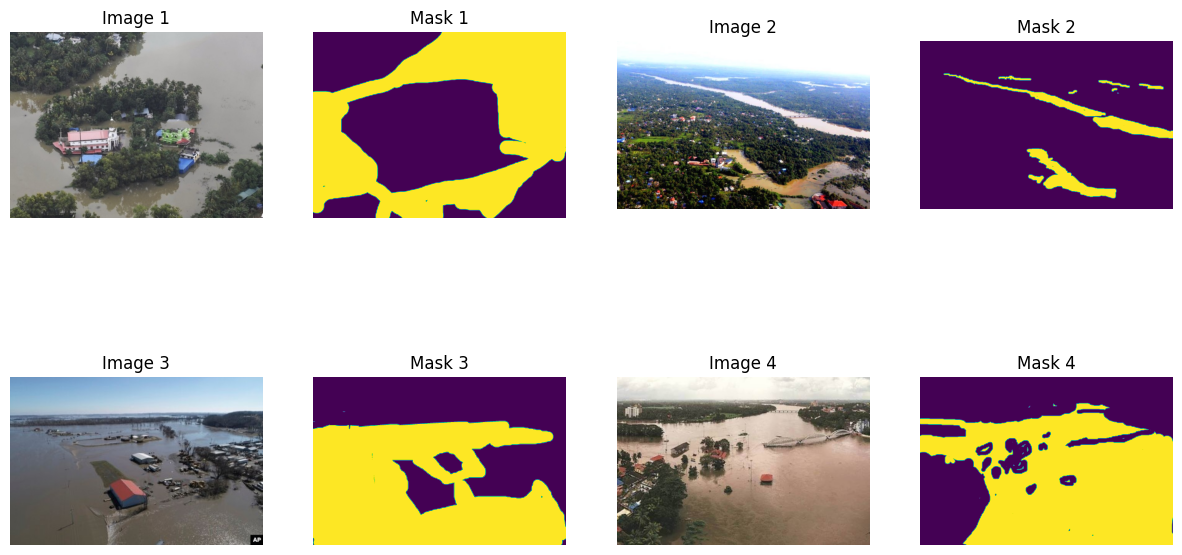

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(4):
    img_path = image_list[i]
    mask_path = image_list[i].replace('Image', 'Mask').replace('jpg', 'png')
    
    axes[2 * i].imshow(Image.open(img_path))
    axes[2 * i].set_title(f'Image {i+1}')
    axes[2 * i].axis('off')
    
    axes[2 * i + 1].imshow(Image.open(mask_path))
    axes[2 * i + 1].set_title(f'Mask {i+1}')
    axes[2 * i + 1].axis('off')

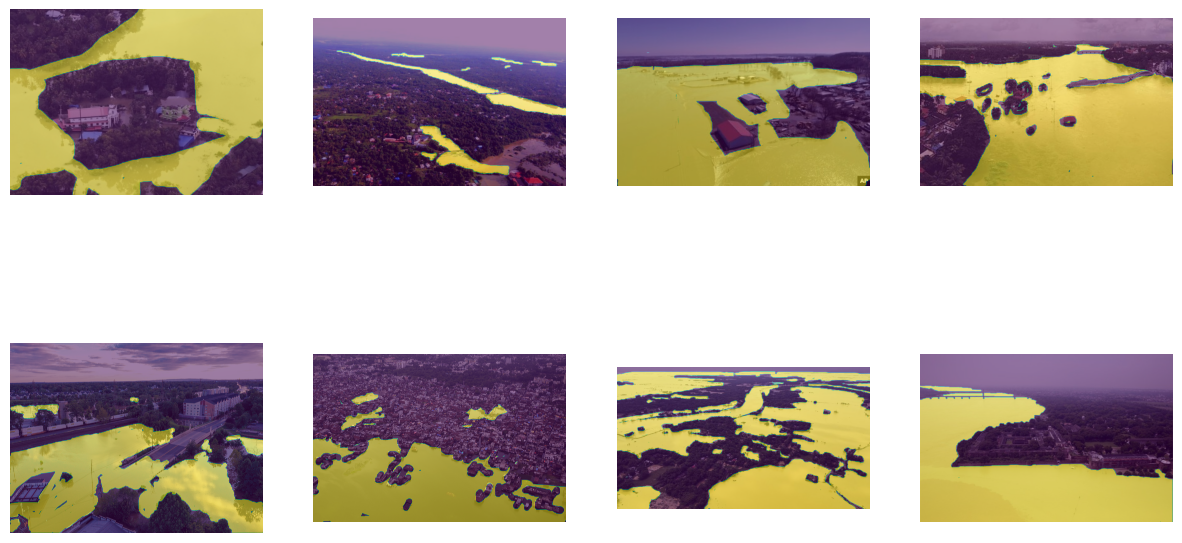

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    img_path = image_list[i]
    mask_path = image_list[i].replace('Image', 'Mask').replace('jpg', 'png')
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    ax.imshow(img)
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')

### 마스크 Binary화 필요

In [5]:
unique, counts = np.unique(mask_list, return_counts=True)
for mask_path in mask_list:
    mask = Image.open(mask_path)
    mask = np.array(mask)
    print(mask)
#     print(mask.shape)
    print(np.unique(mask))
    break

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]
[  0   3   5   6  10  11  13  14  15  16  20  21  24  25  31  32  35  43
  47  48  52  53  54  55  63  64  69  75  76  79  80  87  88  95  96 100
 111 112 120 127 128 143 144 159 160 168 175 176 179 184 191 192 195 203
 207 208 223 224 229 231 239 240 254 255]


### 이미지 데이터 차원 통일

In [6]:
exclude = []

for img_path in image_list:
    img = Image.open(img_path)
    img = np.array(img)
    if img.ndim != 3 or img.shape[2] != 3:
        print(img.shape)
        print(img.ndim)
        print(img_path)
        exclude.append(img_path)

(551, 893)
2
/kaggle/input/flood-area-segmentation/Image/0.jpg
(381, 640)
2
/kaggle/input/flood-area-segmentation/Image/3048.jpg
(450, 640, 4)
3
/kaggle/input/flood-area-segmentation/Image/2.jpg


### 차원 불일치 데이터 제거

In [7]:
for ex in exclude:
    image_list.remove(ex)
    mask_list.remove(ex.replace('Image', 'Mask').replace('jpg', 'png'))

### Dataset

In [8]:
class FloodDataset(Dataset):
    def __init__(self, image_list, mask_list, transform):
        
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        
        return len(self.image_list)
    
    def __getitem__(self, idx):
        
        image_path = self.image_list[idx]
        mask_path = image_path.replace('Image', 'Mask').replace('jpg', 'png')
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)
        
        mask = (mask > 0.5).float()
        
        return image, mask

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((224, 224)),
                               ])

### DataLoader

In [10]:
flood_dataset = FloodDataset(image_list, mask_list, transform = transform)
print(flood_dataset.__len__())

train_size = int(0.8 * len(flood_dataset))
val_size = len(flood_dataset) - train_size

train_ds, val_ds = random_split(flood_dataset, [train_size, val_size])
print(f"Train dataset size: {len(train_ds)} | Validation dataset size: {len(val_ds)}")

train_dl = DataLoader(train_ds, batch_size = 16, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 16, shuffle = False)

imgs, masks = next(iter(train_dl))
print(imgs.shape, masks.shape)

287
Train dataset size: 229 | Validation dataset size: 58
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])


## 학습 및 추론


### 모델 구현
아래 그림과 조건에 맞게 모델을 구현해봅니다.
![](https://velog.velcdn.com/images%2Fleejaejun%2Fpost%2Fc3b69a0d-2329-4903-9baa-de2949af87fb%2Fimage.png)

- VGG16 Backbone을 활용
    - VGG16 Backbone은 총 5개의 Conv block으로 구성
    - 이미지를 Backbone에 통과
    - 추가 Conv layer 2개를 통과
    - 마지막 Feature map Channel size = class num과 같아야 함
- Skip connection
    - 3, 4번 block을 통과한 Feature map을 재사용
    - Upsampling Feature map과 더하기 위하여 Channel size 조정 필요
    - 결합 방식: tensor_1 + tensor_2(더하기 연산)
- Upsampling
    - 두 개의 Upsampling 레이어를 통과
    - 총 세 번 Upsampling(2배 증가 2번, 8배 증가 1번)
    - 첫 번째 2배 증가 후 4번 Block과 결합
    - 두 번째 2배 증가 후 3번 Block과 결합

In [11]:
class FCN8s(nn.Module):
    def __init__(self, n_classes):
        super(FCN8s, self).__init__()
        vgg = models.vgg16(pretrained=True)
        features = list(vgg.features.children())

        # VGG16의 각 블록을 PyTorch Sequential로 구성
        self.block3 = nn.Sequential(*features[:17])  # Conv1 ~ Conv3
        self.block4 = nn.Sequential(*features[17:24])  # Conv4
        self.block5 = nn.Sequential(*features[24:])  # Conv5

        # 추가 Conv 레이어
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7, padding=3)
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)

        # FCN에서 사용할 1x1 Conv
        self.conv1x1_pool3 = nn.Conv2d(256, n_classes, kernel_size=1)
        self.conv1x1_pool4 = nn.Conv2d(512, n_classes, kernel_size=1)
        self.conv1x1_output = nn.Conv2d(4096, n_classes, kernel_size=1)

        # Transposed convolutions for upsampling
        self.upconv2 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, padding=1)
        self.upconv8 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=8, stride=8, padding=0)

    def forward(self, x):
        # YOUR CODE
        
        # Encoder
        x = self.block3(x) # (3, 256, 256) => (256, 32, 32) H/8 W/8
        sample1 = self.conv1x1_pool3(x)
        x = self.block4(x) # (256, 32, 32) => (512, 16, 16) H/16 W/16
        sample2 = self.conv1x1_pool4(x)
        x = self.block5(x) # (512, 16, 16) => (512, 8, 8) H/32 W/32
        x = F.relu(self.conv6(x)) # (512, 8, 8) => (4096, 8, 8) H/32
        x = F.relu(self.conv7(x)) # (4096, 8, 8) => (4096, 8, 8) H/32
        
        # Decoder
        x = self.conv1x1_output(x) # (4096, 8, 8) => (1, 8, 8)
        x = self.upconv2(x) # (1, 8, 8) => (1, 16, 16)
        x = sample2 + x
        x = self.upconv2(x) # (1, 16, 16) => (1, 32, 32)
        x = sample1 + x
        output = self.upconv8(x) # (1, 32, 32) => (1, 256, 256)
        
        return output

In [41]:
# 모델 인스턴스 생성
model = FCN8s(n_classes=1).to(device)

input_image = torch.randn(1, 3, 224, 224).to(device)

output = model(input_image)
print(output.shape)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 224, 224])


### 학습 루프 설정

In [42]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 5e-4)
epochs = 20

### 평가 지표

In [43]:
def IoU(output, mask):
    """
    1. pred를 threshold 기준 Binary 분류
    2. pred과 gt 사이 교집합 영역(픽셀) 계산
    3. pred와 gt의 합집합 영역 계산
    4. zero division 방지
    """
    
    output = (output > 0.5).float()
    
    intersection = torch.sum(output * mask)
    union = torch.sum(output) + torch.sum(mask) - intersection
        
    return intersection / union + 1e-7
    
    
def PA(output, mask):
    """
    1. pred를 threshold 기준 Binary 분류
    2. pred과 gt 일치 여부 계산
    3. 전체 픽셀 중 일치 픽셀 수 반환
    """
    
    output = (output > 0.5).float()
    
    correct = torch.sum(output == mask)
    total = torch.numel(output)
    
    return correct / total

### 학습 루프 함수

In [44]:
model.to(device)

FCN8s(
  (block3): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
def train_and_validate(model, train_loader, val_loader, optim, criterion, epochs):
    train_losses = []
    train_IoUs = []
    train_PAs = []
    val_losses = []
    val_IoUs = []
    val_PAs = []
    
    for epoch in range(epochs):
        print(f'Epoch : {epoch + 1}-------------------------------------')
        
        train_loss = 0
        train_IoU = 0
        train_PA = 0
        model.train()
        for img, mask in tqdm(train_loader):
            
            img = img.to(device)
            mask = mask.to(device)
            
            optim.zero_grad()
            
            output = model(img)
            loss = criterion(output, mask)
            
            loss.backward()
            optim.step()
            
            iou = IoU(output, mask)
            pa = PA(output, mask)
        
            train_loss += loss.item()
            train_IoU += iou.item()
            train_PA += pa.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_IoU = train_IoU / len(train_loader)
        avg_train_PA = train_PA / len(train_loader)
            
        
        train_losses.append(avg_train_loss)
        train_IoUs.append(avg_train_IoU)
        train_PAs.append(avg_train_PA)
        
        print(f'Train_Loss : {avg_train_loss}, Train_IoU : {avg_train_IoU}, Train_PA : {avg_train_PA}')
        
        val_loss = 0
        val_IoU = 0
        val_PA = 0
        model.eval()
        with torch.no_grad():
            for img, mask in tqdm(val_loader):
                
                img = img.to(device)
                mask = mask.to(device)
                
                output = model(img)
                
                loss = criterion(output, mask)
                iou = IoU(output, mask)
                pa = PA(output, mask)

                val_loss += loss.item()
                val_IoU += iou.item()
                val_PA += pa.item()

            avg_val_loss = val_loss / len(val_loader)
            avg_val_IoU = val_IoU / len(val_loader)
            avg_val_PA = val_PA / len(val_loader)


            val_losses.append(avg_val_loss)
            val_IoUs.append(avg_val_IoU)
            val_PAs.append(avg_val_PA)

            print(f'Val_Loss : {avg_val_loss}, Val_IoU : {avg_val_IoU}, Val_PA : {avg_val_PA}')
            
    return train_losses, train_IoUs, train_PAs, val_losses, val_IoUs, val_PAs


### 학습

In [46]:
train_losses, train_IoUs, train_PAs, val_losses, val_IoUs, val_PAs = train_and_validate(model, train_dl, val_dl, optim, criterion, epochs)

Epoch : 1-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.6834897875785828, Train_IoU : 0.0018708525765750513, Train_PA : 0.5807639420032501


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.6741878390312195, Val_IoU : 0.004858758416958153, Val_PA : 0.6231345385313034
Epoch : 2-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.6708613157272338, Train_IoU : 0.07051378628239036, Train_PA : 0.5967933217684428


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.6543641984462738, Val_IoU : 0.12852238677442074, Val_PA : 0.6382657885551453
Epoch : 3-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.6488709926605225, Train_IoU : 0.18330886612335842, Train_PA : 0.6173131585121154


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.6276034265756607, Val_IoU : 0.2893257327377796, Val_PA : 0.6858725994825363
Epoch : 4-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.6188597162564595, Train_IoU : 0.27412960131963093, Train_PA : 0.6497190395991007


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.590180292725563, Val_IoU : 0.2710552103817463, Val_PA : 0.6625199019908905
Epoch : 5-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.5818356911341349, Train_IoU : 0.32437411447366077, Train_PA : 0.6700561245282491


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.5526972860097885, Val_IoU : 0.3753928914666176, Val_PA : 0.7061148285865784
Epoch : 6-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.5419801553090413, Train_IoU : 0.3888112316528956, Train_PA : 0.7053727189699809


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.5170594751834869, Val_IoU : 0.33228208124637604, Val_PA : 0.7011869996786118
Epoch : 7-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.5131643732388814, Train_IoU : 0.44282297492027284, Train_PA : 0.7323771198590596


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.4729720875620842, Val_IoU : 0.47270517796278, Val_PA : 0.7587906569242477
Epoch : 8-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.4599881907304128, Train_IoU : 0.5018569350242614, Train_PA : 0.7620526671409606


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.4312341809272766, Val_IoU : 0.51089046895504, Val_PA : 0.7837710976600647
Epoch : 9-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.4186878800392151, Train_IoU : 0.541308605670929, Train_PA : 0.7885265668233236


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.3888617977499962, Val_IoU : 0.5657915621995926, Val_PA : 0.8171978145837784
Epoch : 10-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.38787792921066283, Train_IoU : 0.5862253348032633, Train_PA : 0.8150894562403361


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.3627438098192215, Val_IoU : 0.5644774287939072, Val_PA : 0.8296617567539215
Epoch : 11-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.36376517415046694, Train_IoU : 0.6031117081642151, Train_PA : 0.8242530266443888


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.3620108738541603, Val_IoU : 0.6229041069746017, Val_PA : 0.8450559377670288
Epoch : 12-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.3413420001665751, Train_IoU : 0.6508884429931641, Train_PA : 0.84441210826238


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.36369188129901886, Val_IoU : 0.645597979426384, Val_PA : 0.8533919602632523
Epoch : 13-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.3235081215699514, Train_IoU : 0.676214047273, Train_PA : 0.860738213857015


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.31911803781986237, Val_IoU : 0.5817791372537613, Val_PA : 0.840264692902565
Epoch : 14-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.31354308128356934, Train_IoU : 0.7037979145844777, Train_PA : 0.8680759032567342


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.29699552059173584, Val_IoU : 0.7022595107555389, Val_PA : 0.8819482624530792
Epoch : 15-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.2958470662434896, Train_IoU : 0.7166707078615825, Train_PA : 0.8734918038050333


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.29072096198797226, Val_IoU : 0.7188597321510315, Val_PA : 0.8855829834938049
Epoch : 16-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.27528348565101624, Train_IoU : 0.7425311406453451, Train_PA : 0.8853416959444682


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.28705476596951485, Val_IoU : 0.7287377417087555, Val_PA : 0.889265701174736
Epoch : 17-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.2713269819815954, Train_IoU : 0.7398771127065022, Train_PA : 0.8832858443260193


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.26987462118268013, Val_IoU : 0.7165340930223465, Val_PA : 0.8873772770166397
Epoch : 18-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.3202871948480606, Train_IoU : 0.7029716809590657, Train_PA : 0.8654352188110351


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.30588672310113907, Val_IoU : 0.6320689767599106, Val_PA : 0.8571247160434723
Epoch : 19-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.3011490643024445, Train_IoU : 0.7059925357500713, Train_PA : 0.867588980992635


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.32612958550453186, Val_IoU : 0.6919288337230682, Val_PA : 0.8697234392166138
Epoch : 20-------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Train_Loss : 0.2905991057554881, Train_IoU : 0.7078401724497477, Train_PA : 0.8713507254918417


  0%|          | 0/4 [00:00<?, ?it/s]

Val_Loss : 0.2974890321493149, Val_IoU : 0.7093354165554047, Val_PA : 0.8784519582986832


### 로그 시각화

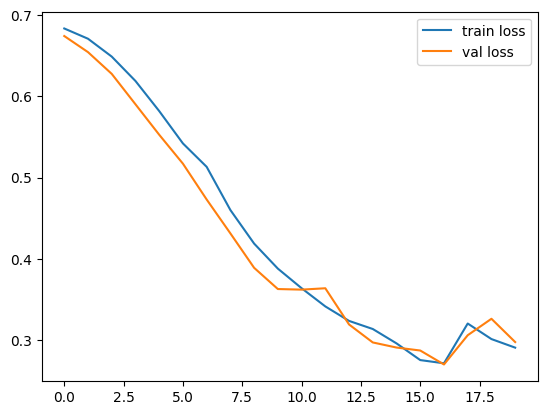

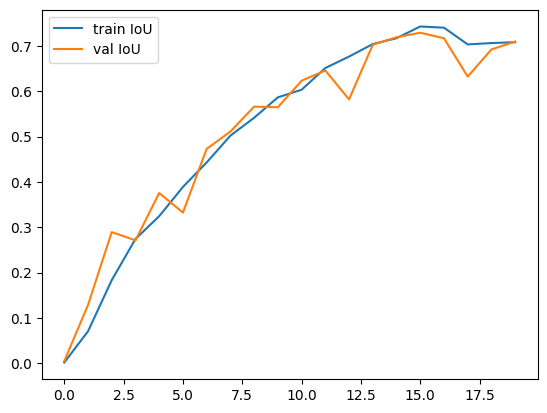

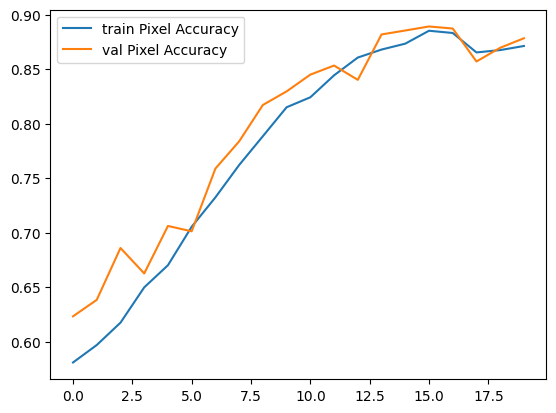

In [48]:
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')
plt.legend()
plt.show()
plt.plot(train_IoUs, label = 'train IoU')
plt.plot(val_IoUs, label = 'val IoU')
plt.legend()
plt.show()
plt.plot(train_PAs, label = 'train Pixel Accuracy')
plt.plot(val_PAs, label = 'val Pixel Accuracy')
plt.legend()
plt.show()

In [50]:
def plot_batch(model, data_loader):
    model.eval()
    with torch.no_grad():
        for img, mask in tqdm(data_loader):
            img = img.to(device)
            output = model(img)
            output = (output > 0.5).float()
            img = img.cpu().numpy().transpose(0, 2, 3, 1)
            mask = mask.cpu().numpy().transpose(0, 2, 3, 1)
            output = output.cpu().numpy().transpose(0, 2, 3, 1)
            break
    for i in range(data_loader.batch_size):
        fig, ax = plt.subplots(1, 3, figsize = (15, 5))
        ax[0].imshow(img[i])
        ax[0].set_title('image')
        ax[1].imshow(mask[i], cmap = 'gray')
        ax[1].set_title('mask')
        ax[2].imshow(output[i], cmap = 'gray')
        ax[2].set_title('predicted mask')
        plt.show()

### 결과 비교

  0%|          | 0/4 [00:00<?, ?it/s]

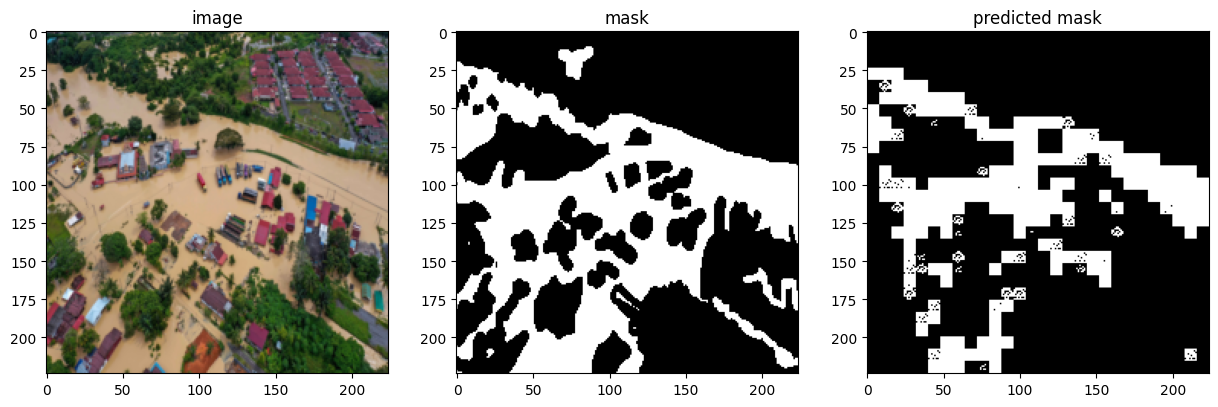

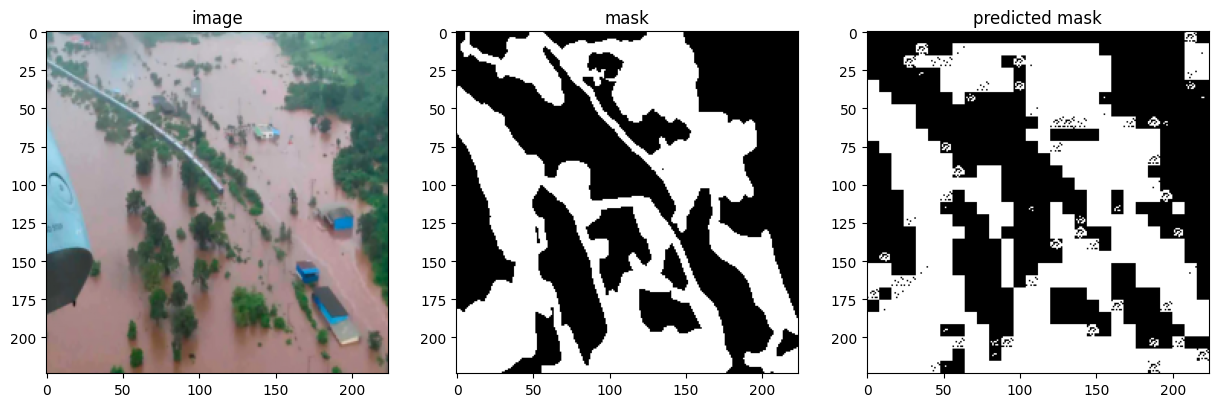

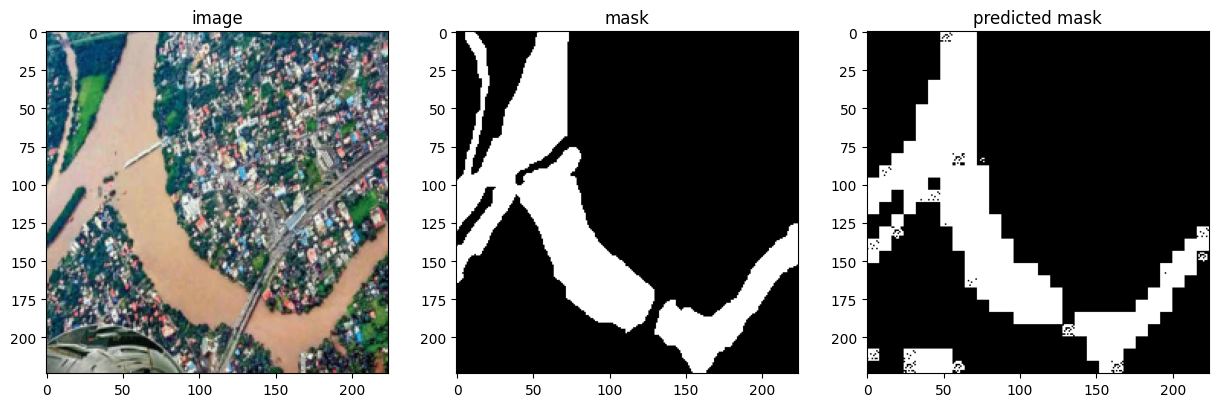

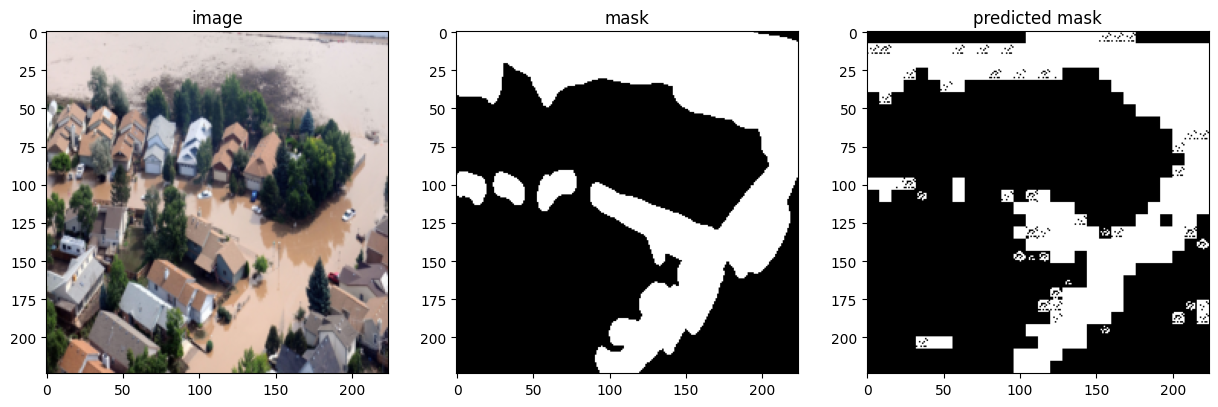

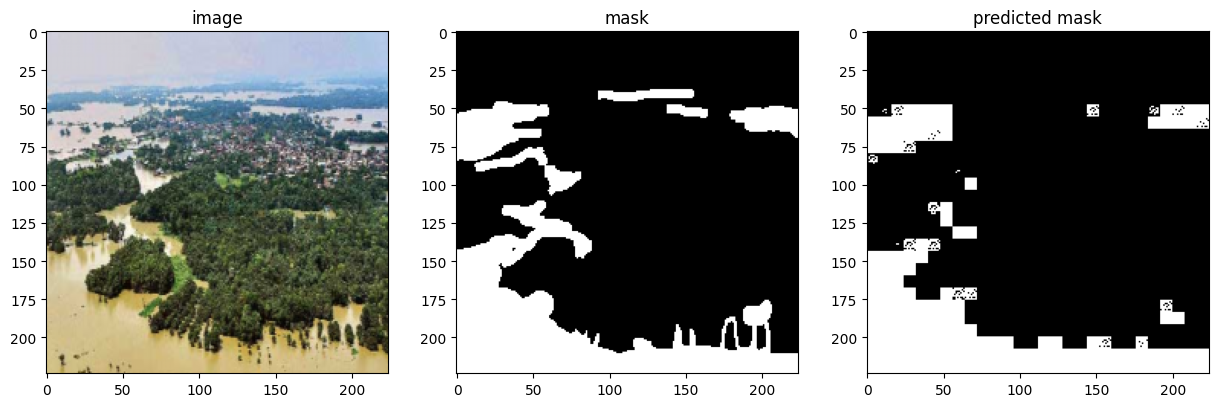

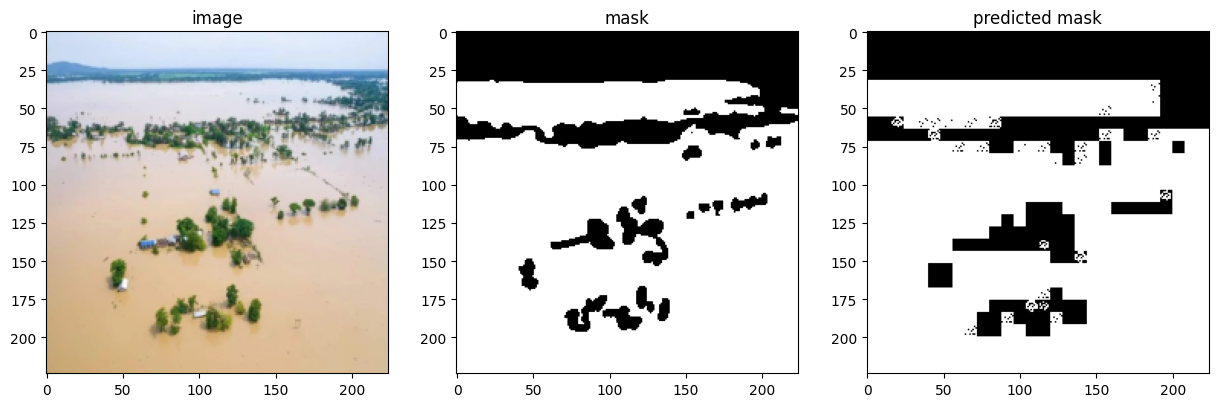

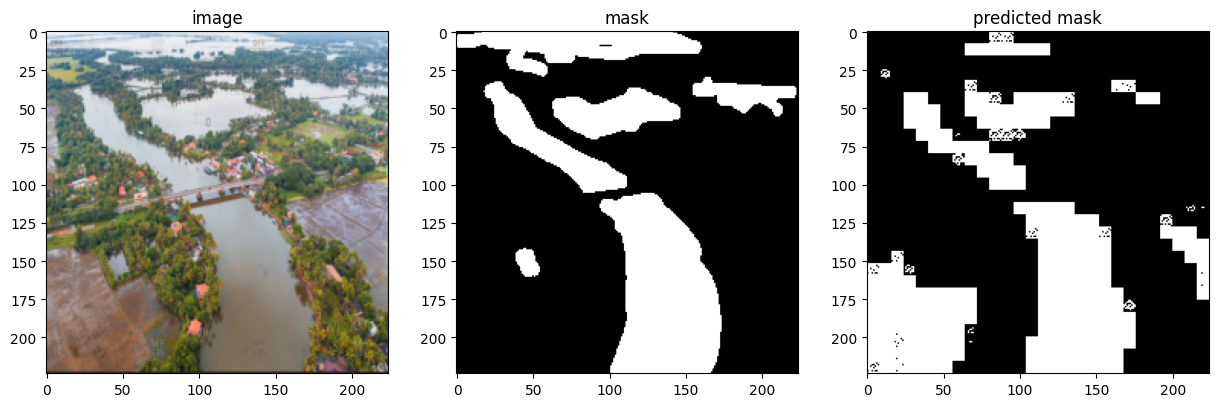

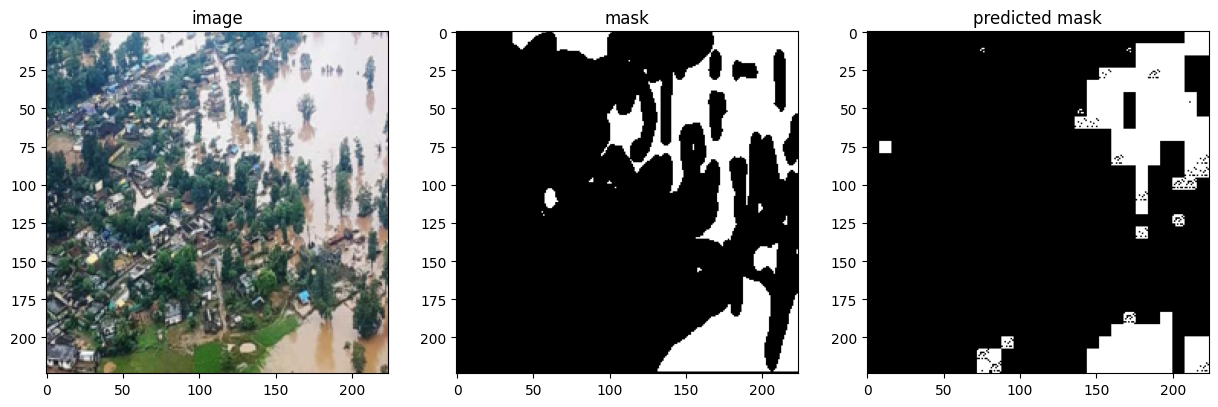

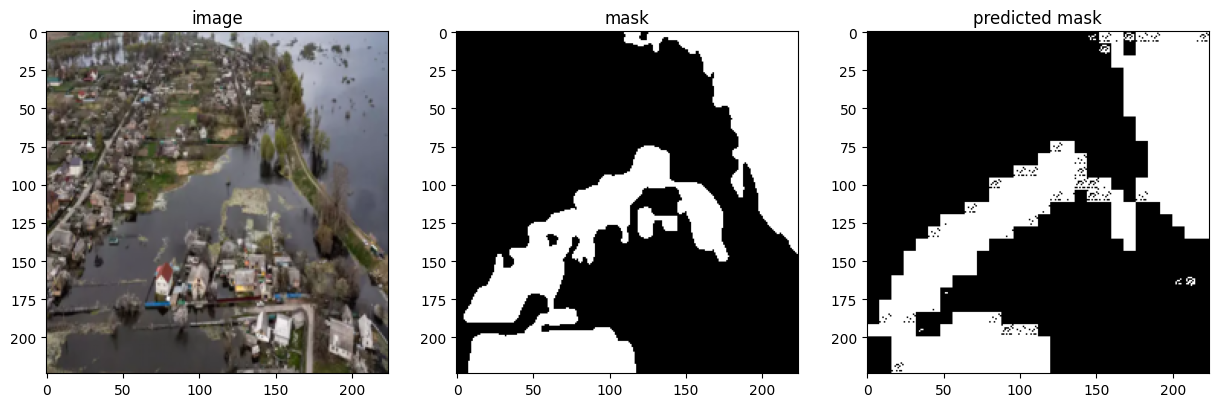

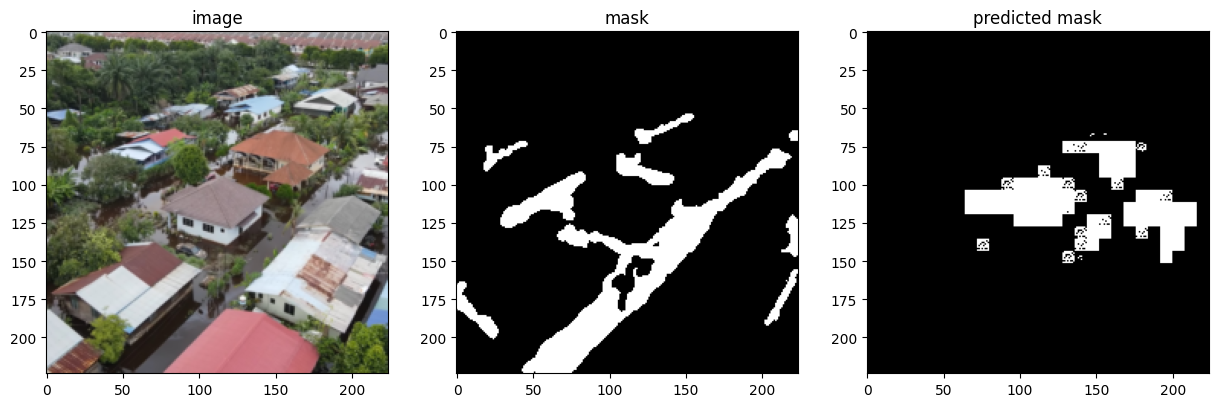

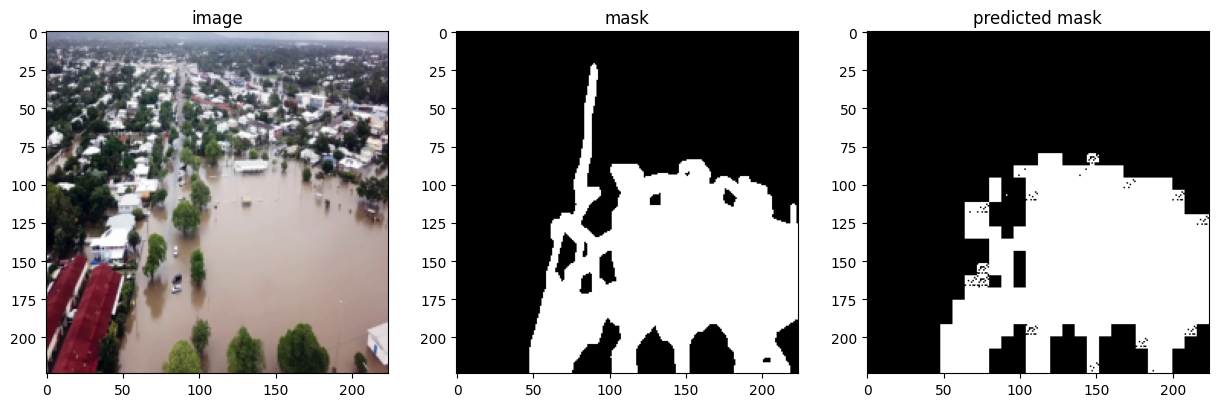

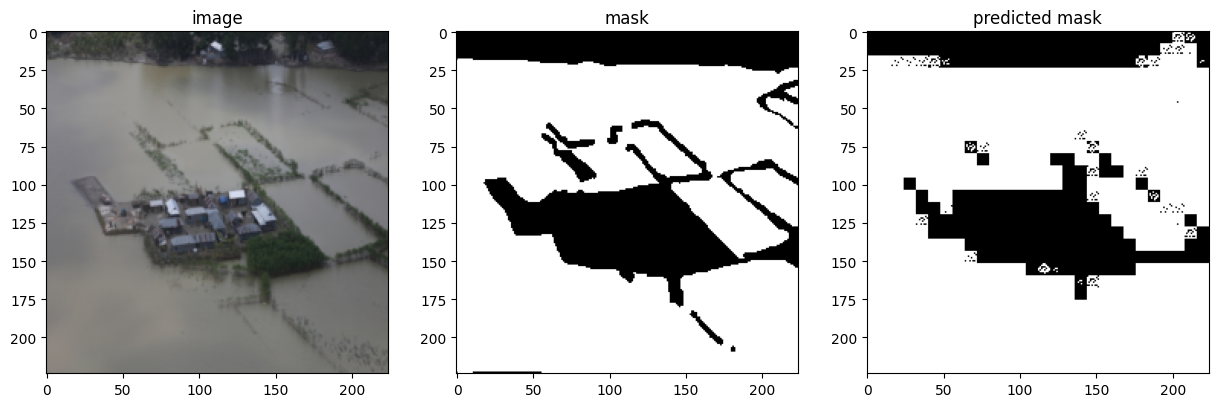

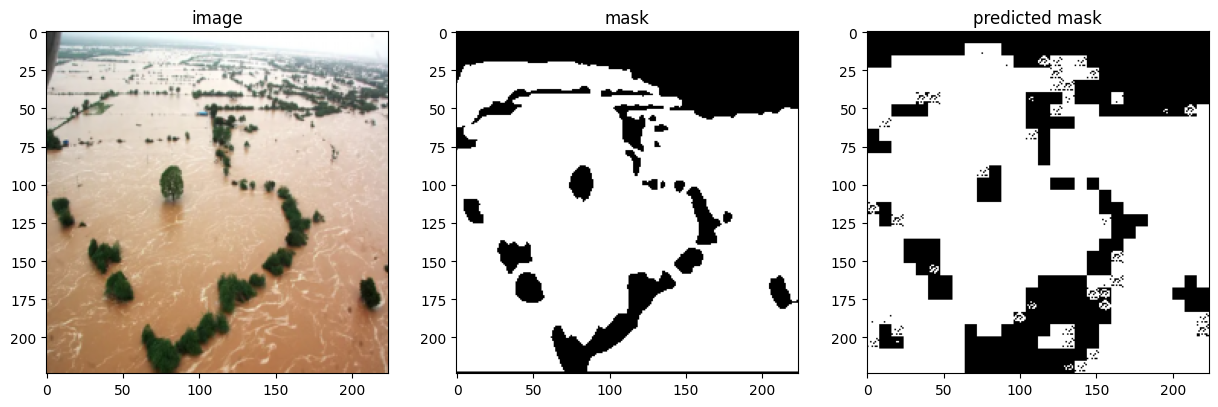

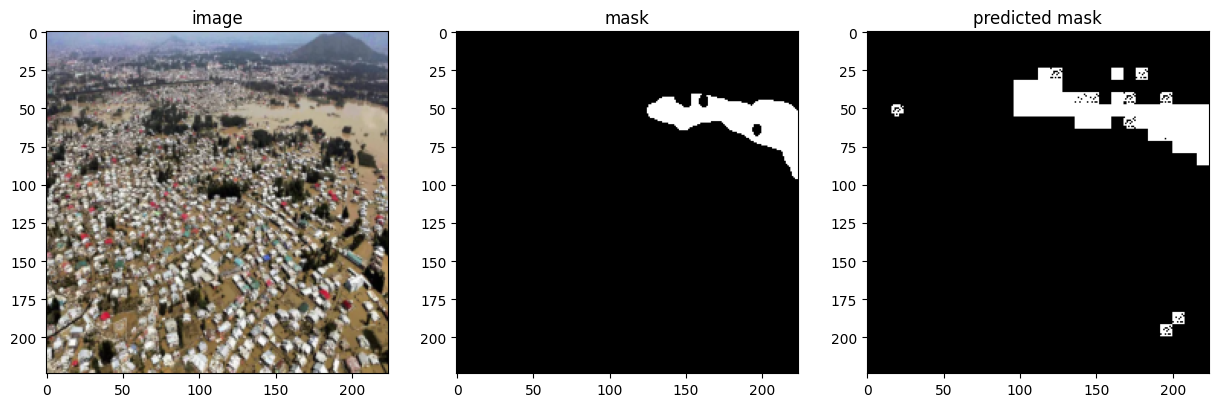

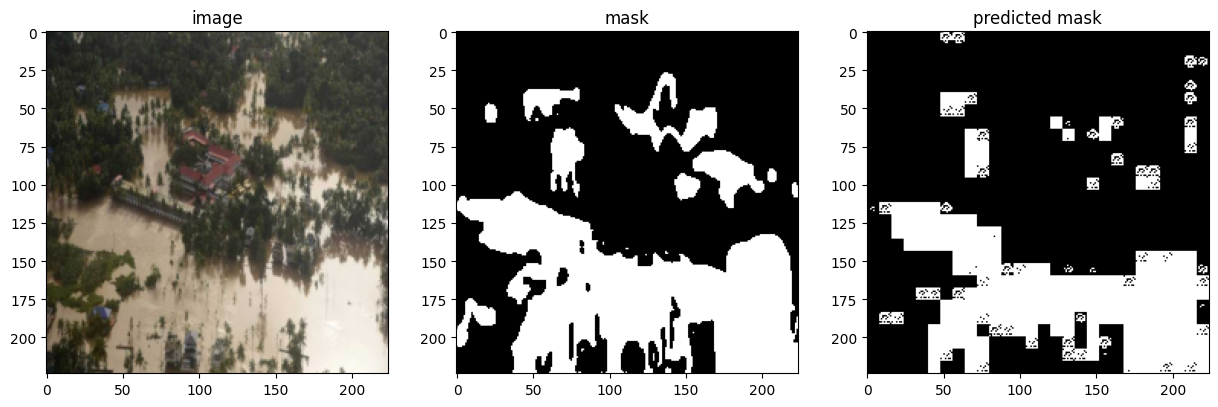

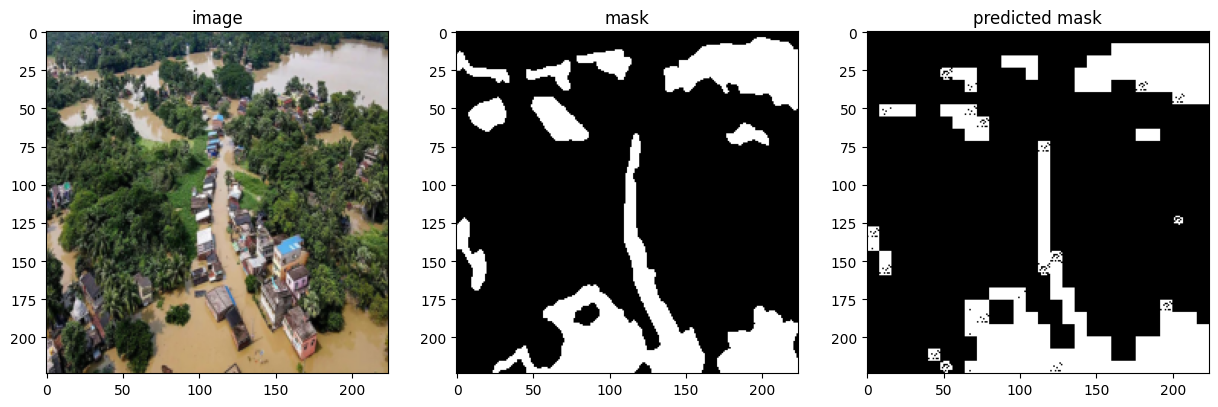

In [51]:
plot_batch(model, val_dl)